# Mesoscale structure analyses
First Figure:
This notebook goes through the steps of creating a stacked bar chart for connectome data. It pulls the modularity data and the synaptic weight data for oviIN_r's inputs. 

1. Finds the top connections to oviINr
2. Merges the modularity and synaptic weight data on the bodyId column
3. Groups the dataframe by celltype and module id number while adding up the weights if they need to
4. Table is pivoted so that the modules are the columns
5. Totals are added up of the celltypes to sort and check results
6. Stacked bar plot shows the module id that the celltypes are sorted into

Second Figure
- We wanted to see here wether the largest inputs were mainly in one module or if there was some pattern to the primacy of the largest inputs within their modules.

This was done by finding the rank of ovis to the Input celltypes (was oviIN their highest output)

Written by Rhessa Weber Langstaff (auth_token file path is for my work computer, I will need to change this)

In [1]:
# Imports
import numpy as np
import pandas as pd

In [2]:
# load package
import matplotlib
import matplotlib.patheffects as path_effects
import matplotlib as mpl
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'MacOSX', etc.
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator
%matplotlib inline

In [ ]:

# Set 'pdf.fonttype' to 42 to keep the text editable after exporting to pdf
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams['font.size'] = 14  # Default text size
plt.rcParams['axes.titlesize'] = 18  # Title size
plt.rcParams['figure.titlesize'] = 18  # Figure title size
plt.rcParams['axes.labelsize'] = 14  # X and Y label size
plt.rcParams['xtick.labelsize'] = 12  # X tick label size
plt.rcParams['ytick.labelsize'] = 12  # Y tick label size
plt.rcParams['legend.fontsize'] = 12  # Legend font size

In [3]:
from neuprint import Client

auth_token_file = open("flybrain.auth.txt", 'r') # need file containing the authentication token
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + 'v1.2.1', token=auth_token)
    np_client.fetch_version()
except:
    np_client = None

## Obtain the sub-connectome of inputs to oviIN_R
We obtain a sub-connectome for oviIN_R's inputs that is composed only of Traced neurons. The undirected graph is exported as a .txt file to be used by RenEEL for modularity analysis.

In [4]:
# body ID of oviIN_R from Neuprint
oviINr_bodyID = 423101189

In [5]:
# use our function to get connectome
from get_connectome import get_connectome

oviINr_connectome = get_connectome(oviINr_bodyID, exclude_main_neurons=True, connectome_scope='input')
oviINr_connectome

  0%|          | 0/10 [00:00<?, ?it/s]

,bodyId_pre,bodyId_post,weight
0,263674097,298258513,28
1,263674097,325743813,1
2,263674097,329225149,2
3,263674097,361312808,6
4,263674097,387568523,2
...,...,...,...
203146,7112622044,5813096198,2
203147,7112622044,5813098223,5
203148,7112622044,5813109327,3
203149,7112622044,5813111272,1


In [6]:
# make the connectome undirected
from get_connectome import connectome_to_undirected

oviINr_connectome_undirected = connectome_to_undirected(oviINr_connectome)
oviINr_connectome_undirected

,source,target,weight
0,263674097,298258513,32
1,263674097,325743813,1
2,263674097,329225149,2
3,263674097,361312808,6
4,263674097,387568523,2
...,...,...,...
165031,7112622044,5813063587,6
165032,7112622044,5813065004,1
165033,7112622044,5813080768,10
165034,7112622044,5813096198,2


In [ ]:
# export the connectome to a txt file
oviINr_connectome_undirected.to_csv('modularity_runs/oviINr_in_connectome_undirected_selfremoved.txt', index = False, header=False)

The connectome can be run through our gcm_pipeline and then the modularity results can be read in after running.

In [7]:
import pandas as pd

mod = pd.read_csv('modularity_runs/0.0/0-0_98765.txt',header=None, sep=' ')
mod.columns = ['id', '0.0']
mod

,id,0.0
0,1003215282,1
1,1005952640,2
2,1006928515,3
3,1007260806,3
4,1008024276,4
...,...,...
1827,987117151,2
1828,987273073,6
1829,988567837,5
1830,988909130,5


## Inputs to oviIN_R

We obtain the oviINr's inputs using fetch_simple_connections, these include all Primary ROI and the NotPrimary category defined by Janelia. This section sets up the data variables needed throughout the file.

We fetch connections only with the traced, non-cropped neurons from the sub-connectome. Note that this excludes the few neurons that made no connections within the sub-connectome. Those would have been dropped from the graph anyway and would never have been assigned to a module.

[ovi_in_merged is an important DF that we will use multiple times in this notebook.]

In [8]:
from neuprint import fetch_simple_connections

# inputs to the oviINr
#ovi_inputs = fetch_simple_connections(None, oviINr_bodyID)
ovi_inputs = fetch_simple_connections(mod['id'], oviINr_bodyID)
ovi_inputs

,bodyId_pre,bodyId_post,weight,type_pre,type_post,instance_pre,instance_post,conn_roiInfo
0,611015907,423101189,287,SMP176,oviIN,SMP176_R,oviIN_R,"{'INP': {'pre': 54, 'post': 53}, 'CRE(R)': {'p..."
1,5813087891,423101189,255,SMP544,oviIN,SMP544_R,oviIN_R,"{'LX(R)': {'pre': 66, 'post': 65}, 'LAL(R)': {..."
2,1598011458,423101189,243,LAL134,oviIN,LAL134_R,oviIN_R,"{'LX(R)': {'pre': 42, 'post': 42}, 'LAL(R)': {..."
3,5813022375,423101189,236,IB017,oviIN,IB017_R,oviIN_R,"{'SNP(R)': {'pre': 97, 'post': 97}, 'SMP(R)': ..."
4,448342846,423101189,225,CRE075,oviIN,CRE075_R,oviIN_R,"{'INP': {'pre': 199, 'post': 199}, 'CRE(R)': {..."
...,...,...,...,...,...,...,...,...
1827,5901201909,423101189,1,SLP013,oviIN,SLP013_R,oviIN_R,"{'SNP(R)': {'pre': 1, 'post': 1}, 'SMP(R)': {'..."
1828,5901203505,423101189,1,SLP212,oviIN,SLP212_R,oviIN_R,"{'SNP(R)': {'pre': 1, 'post': 1}, 'SMP(R)': {'..."
1829,5901215966,423101189,1,SMP400,oviIN,SMP400(PDM09)_L,oviIN_R,"{'SNP(L)': {'pre': 1, 'post': 1}, 'SMP(L)': {'..."
1830,5901218930,423101189,1,CRE043_a,oviIN,CRE043_a_R,oviIN_R,"{'LX(R)': {'pre': 1, 'post': 1}, 'LAL(R)': {'p..."


In [9]:
# Merge weights to oviIN onto modularity data
ovi_in_merged = pd.merge(mod, ovi_inputs, how='left', left_on='id', right_on='bodyId_pre')

# Extract the columns we need
ovi_in_merged = ovi_in_merged[['type_pre','0.0','weight']]

ovi_in_merged

,type_pre,0.0,weight
0,CL229,1,1
1,IB058,2,3
2,CL300,3,1
3,CL301,3,7
4,FB5N,4,1
...,...,...,...
1827,LAL010,2,14
1828,None,6,1
1829,FB4G,5,1
1830,FB5V,5,1


## Define colors

Color palette used across all modularity figures

In [10]:
colors = ['#4e90d3', '#9467bd', '#e7cf57', '#ff6a88', '#5cc9ff', '#3a9f82', '#9fad2b']
colors

# plot darker colors
plt.figure(figsize=(8,2))
for i, color in enumerate(colors):
    plt.bar(i, 1, color=color, edgecolor='black')

# Celltype Synapse counts by Coarse Module

This section will isolate the top connections (weights>=100) to the oviIN and label them by the cluster they grouped into by the modularity.


In [11]:
# inputs to oviINr and using only necessary columns
ovi_inputs_filter = ovi_inputs[['type_pre','weight']]  

# collapse ovi_inputs by cell type and sort in descending order
ovi_inputs_top = ovi_inputs_filter.groupby('type_pre', as_index=False).sum().sort_values(by='weight', ascending=False,ignore_index=True)

# filter out cell types with less than 100 inputs
ovi_inputs_final = ovi_inputs_top[ovi_inputs_top['weight'] >= 100]

ovi_inputs_final.head()

,type_pre,weight
0,FS1A,892
1,SMP052,361
2,FC2B,290
3,SMP176,287
4,SMP383,281


In [12]:
print('The length of the top connections to the oviIN are', len(ovi_inputs_final))

The length of the top connections to the oviIN are 32


In [13]:
# Collapse the table by celltype and number in 0.0, adding up the weights
#ovi_in_collapsed = ovi_in_merged.groupby(['celltype','0.0'], as_index=False).sum()
ovi_in_collapsed = ovi_in_merged.groupby(['type_pre','0.0'], as_index=False).sum()

ovi_in_collapsed

,type_pre,0.0,weight
0,5-HTPMPD01,7,3
1,5-HTPMPV01,3,3
2,5-HTPMPV03,3,1
3,AOTU003,2,1
4,AOTU008_a,3,1
...,...,...,...
1021,pC1d,3,109
1022,pC1e,3,148
1023,v2LN37,6,4
1024,vpoDN,7,2


In [14]:
# Pivot the table so that the columns are the number of inputs and the rows are the cell types
#ovi_in_pivot = ovi_in_collapsed.pivot(index='celltype', columns='0.0', values='weight')
ovi_in_pivot = ovi_in_collapsed.pivot(index='type_pre', columns='0.0', values='weight')

ovi_in_pivot

0.0,1,2,3,4,5,6,7
type_pre,,,,,,,
5-HTPMPD01,NaN,NaN,NaN,NaN,NaN,NaN,3.0
5-HTPMPV01,NaN,NaN,3.0,NaN,NaN,NaN,NaN
5-HTPMPV03,NaN,NaN,1.0,NaN,NaN,NaN,NaN
AOTU003,NaN,1.0,NaN,NaN,NaN,NaN,NaN
AOTU008_a,NaN,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
pC1d,NaN,NaN,109.0,NaN,NaN,NaN,NaN
pC1e,NaN,NaN,148.0,NaN,NaN,NaN,NaN
v2LN37,NaN,NaN,NaN,NaN,NaN,4.0,NaN


In [15]:
# Filter celltypes for those in ovi_inputs_final
ovi_in_pivot = ovi_in_pivot[ovi_in_pivot.index.isin(ovi_inputs_final['type_pre'])]


# Add total number of inputs to each cell type
ovi_in_pivot['total'] = ovi_in_pivot.sum(axis=1)


# Sort by total number of inputs
ovi_in_pivot = ovi_in_pivot.sort_values(by='total', ascending=False)

# Drop total column so it doesn't get plotted
ovi_in_pivot = ovi_in_pivot.drop(columns='total')

# INdex to each column and set them to the column name
ovi_in_pivot.columns = range(0, ovi_in_pivot.shape[1])
# fill in NaN values with 0
ovi_in_pivot = ovi_in_pivot.fillna(0)
ovi_in_pivot.reset_index()

/var/folders/qb/p6dbns6n14n6pl5jy5tkwp78xfrsnf/T/ipykernel_9500/1714575733.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ovi_in_pivot['total'] = ovi_in_pivot.sum(axis=1)


,type_pre,0,1,2,3,4,5,6
0,FS1A,0.0,0.0,0.0,892.0,0.0,0.0,0.0
1,SMP052,361.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FC2B,0.0,0.0,0.0,290.0,0.0,0.0,0.0
3,SMP176,287.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SMP383,281.0,0.0,0.0,0.0,0.0,0.0,0.0
5,SMP544,4.0,255.0,0.0,0.0,0.0,0.0,0.0
6,LAL134,4.0,243.0,0.0,0.0,0.0,0.0,0.0
7,IB017,0.0,0.0,0.0,0.0,236.0,0.0,0.0
8,CRE075,0.0,0.0,0.0,0.0,225.0,0.0,0.0
9,SMP566,0.0,0.0,0.0,203.0,0.0,0.0,0.0


This table contains the synapse counts for each celltype in the cells. The synapse counts can be in different modules which are the columns. 

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


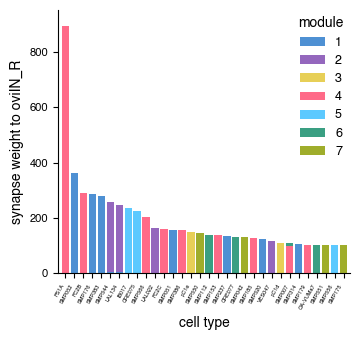

In [39]:
import numpy as np

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(3.7,3.5))

# iterate through each module and plot the stacked bars
for i in range(7):
    ax.bar(ovi_in_pivot.index, ovi_in_pivot[i], bottom=np.sum(ovi_in_pivot.values[:,0:i], axis=1), label=i+1, color=colors[i])#, width=0.55)

#plt.title('Celltype synapse counts to oviINr by coarse module')
plt.xlabel('cell type')
plt.ylabel('synapse weight to oviIN_R')
# get rid of padding to left and right of xtcks
plt.xlim(-0.8, len(ovi_in_pivot.index)-0.3)

# make tick label text larger
plt.xticks
plt.yticks
plt.ylim(0, 950)
plt.legend(title='module', loc='upper right')
plt.xticks(rotation=60, ha='right', fontsize=4)

# make axes fill the figure
#ax.set_position([0, 0, 1, 1])  # [left, bottom, width, height] in figure coordinates

plt.tight_layout()
fig.tight_layout()

plt.savefig('figures/celltype_synapse_counts.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig.savefig('figures/celltype_synapse_counts.svg', format='svg', dpi=1200)

We see in this plot a distribution of modules among oviIN's highest inputs.

# Distribution of the rank of oviIN's inputs

We want to understand how the modularity treats oviIN's top connections. Does it group them all into one big group or is there even representation of the important celltypes across clusters?

Using the dataframe ovi_inputs_final, we have out top inputs to the oviIN. We take ovi_in_merged, groupby type_pre but take majority value and sum weights. We then find where oviIN ranks in each celltype's output by pulling its connections.

In [19]:
# grab the top cell types from ovi_in_merged
ovi_in_merged_top = ovi_in_merged[ovi_in_merged['type_pre'].isin(ovi_inputs_final['type_pre'])]

# sort by weights so that the first module id is the one with the most weight for each cell type
ovi_in_merged_top_sort = ovi_in_merged_top.sort_values(by='weight', ascending=False)
ovi_in_merged_top_sort

,type_pre,0.0,weight
1173,SMP176,1,287
1054,SMP544,2,255
265,LAL134,2,243
914,IB017,5,236
513,CRE075,5,225
...,...,...,...
948,FC2C,4,4
1132,SMP185,4,4
1041,LAL134,1,4
1045,SMP544,1,4


In [20]:
# group by type_pre and take the first module id
ovi_in_merged_top_group = ovi_in_merged_top_sort[['type_pre','0.0']].groupby('type_pre',as_index=False).first()

# sort by module id so that the colors are in the same order on the stacked bar chart
ovi_in_merged_top_group_sort = ovi_in_merged_top_group.sort_values(by='0.0',ascending=True, ignore_index=True)
ovi_in_merged_top_group_sort

,type_pre,0.0
0,SMP051,1
1,SMP314,1
2,SMP237,1
3,SMP176,1
4,SMP520,1
5,SMP052,1
6,SMP383,1
7,VES047,2
8,LAL022,2
9,LAL134,2


ovi_inputs_grouped is a dataframe of the top 33 celltypes with the number of connections they make and what cluster they are in at resolution=0.0

In [21]:
#testchunk = ovi_inputs_final.copy()# Copies dataframe to avoid SettingWithCopyWarning
testchunk = ovi_in_merged_top_group_sort.copy()# Copies dataframe to avoid SettingWithCopyWarning

# Add columns to testchunk
testchunk['out_to_ovis_weight'] = 0
testchunk['out_to_ovis_rank'] = 0

# iterate through each row in testchunk and fetch connections for each cell type in order to find out where oviIN ranks with each cell's outputs
for idx, row in testchunk.iterrows():
    # fetch outputs for each top input of oviIN
    i_outputs = fetch_simple_connections(row.type_pre,None)

    # grab only necessary columns
    i_outputs = i_outputs[['type_post','weight']]

    # collapse outputs by cell type, summing along weights, and sort in descending order
    i_outputs = i_outputs.groupby('type_post', as_index=False).sum().sort_values(by='weight', ascending=False,ignore_index=True)

    # grab the row where oviIN is. there will be 1 row for sum of oviINr and oviINl.
    thing = i_outputs[i_outputs['type_post'] == 'oviIN'].weight

    # add the weight and rank of oviIN in its partners outputs to the testchunk dataframe
    testchunk.loc[idx,'out_to_ovis_weight'] = thing.values[0]
    testchunk.loc[idx,'out_to_ovis_rank'] = thing.index.values[0]

In [22]:
testchunk

,type_pre,0.0,out_to_ovis_weight,out_to_ovis_rank
0,SMP051,1,273,0
1,SMP314,1,131,2
2,SMP237,1,337,0
3,SMP176,1,544,2
4,SMP520,1,258,0
5,SMP052,1,614,0
6,SMP383,1,543,1
7,VES047,2,118,0
8,LAL022,2,201,2
9,LAL134,2,358,0


Testchunk is now a dataframe that has the cluster each celltype is in, their outputs to oviIN and what position the oviIN is ranked out of all the celltypes outputs. This can go from position 0 up to 12.

In [23]:
# Assign colors to each module
testchunk['color'] = testchunk['0.0'].apply(lambda x: colors[x-1])

# Sorting 
testchunk_edit = testchunk.sort_values(by='0.0', ascending=True, ignore_index=True)

# Testchunk drop columns
testchunk_small = testchunk_edit[['type_pre', 'out_to_ovis_rank', 'color']]

# Pivot so that celltypes in the index, and oviIN ranks in the columns and 0.0 is a second level column
testchunk_pivot = testchunk_small.pivot(index='out_to_ovis_rank', columns=['type_pre', 'color'], values='out_to_ovis_rank')

# Replace any non-Nan values with the number 1
testchunk_pivot = testchunk_pivot.notnull().astype('int')

# replace any zeros with NaN
testchunk_pivot = testchunk_pivot.replace(0, np.nan)

# Add in a blank row after 7 to make a separation on plot
testchunk_pivot.loc[10]= np.nan

# Sort the index
testchunk_pivot = testchunk_pivot.sort_index(ascending=True)

testchunk_pivot

type_pre,SMP051,SMP314,SMP237,SMP176,SMP520,SMP052,SMP383,SMP544,LAL134,LAL022,...,SMP556,CRE075,IB017,OA-VUMa7,CRE077,SMP112,SMP551,SMP042,SMP550,SMP175
color,#4e90d3,#4e90d3,#4e90d3,#4e90d3,#4e90d3,#4e90d3,#4e90d3,#9467bd,#9467bd,#9467bd,...,#5cc9ff,#5cc9ff,#5cc9ff,#3a9f82,#3a9f82,#3a9f82,#9fad2b,#9fad2b,#9fad2b,#9fad2b
out_to_ovis_rank,,,,,,,,,,,,,,,,,,,,,
0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Testchunk pivot is a dataframe that gives the official color of the cluster to each celltype and places a True or 1 if the celltype is in that rank. 

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


<Figure size 640x480 with 0 Axes>

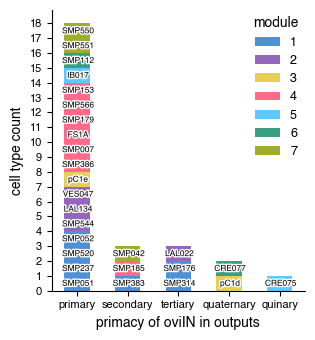

In [26]:
# Plotting the data
fig, ax = plt.subplots(figsize=(3.25,3.5))

# cut down on the number of levels (and therefore bars)
testchunk_pivot = testchunk_pivot.iloc[:5]

# stacked bar plot using 0.0 index as color group
testchunk_pivot.plot(kind='bar', stacked=True, ax=ax, color=testchunk_pivot.columns.get_level_values(1), label=None)

# generate labels for each stacked bar using the cell type names
labels_edit = testchunk_pivot.columns.get_level_values(0).to_list()

# annotate the stacked bar plot
for i in range(len(testchunk_pivot)):
    y = 0
    for j in range(len(testchunk_pivot.columns)):
    #for j in range(6):
        if testchunk_pivot.iloc[i,j] == 1:
            # annotate with black font and white outline
            ax.text(i+0.02, y + 0.5, labels_edit[j], ha='center', va='center', rotation=0, color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground='white')], fontsize=6)
            y += 1

ax.legend().remove()

#make my own legend
for i, color in enumerate(colors):
    ax.bar(0, 0, color=color, label=labels_edit[i])

labels_final = labels_edit + [1,2,3, 4, 5, 6, 7]

# I only want to display the cluster colors
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[32:], labels_final[-7:], loc='upper right', title='module')

plt.xticks(rotation=0)
ax.set_yticks(np.linspace(0, 18, 19))
#ax.set_yticklabels(np.linspace(0, 18, 19, dtype=int))
ax.set_ylabel('cell type count')

ax.set_xlabel('primacy of oviIN in outputs')
#ax.set_title("Output Primacy of the oviINr inputs")
#plt.ylim(0, 19)
xticks = ax.xaxis.get_major_ticks()
#xticks[8].set_visible(False)
ax.set_xticklabels(['primary', 'secondary', 'tertiary', 'quaternary', 'quinary'])

fig.tight_layout()
#plt.xlim(-0.5, 4.5)
plt.savefig("figures/output_primacy_rank_distribution.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
#fig.savefig("figures/output_primacy_rank_distribution.svg", format='svg', dpi=1200)

We can see that the Rank 0 has representation from all clusters. 

# Synaptic Input sites colored by Module Membership

Let's create ovi_pre_syns here, and also export it for re-use since it takes a while to run. Note that it times out when mod['id'] is given as a source, so I had to fetch all the input synapses to oviIN and filter out the mod synapses later.

In [ ]:
# fetch oviINr synapse sites
from neuprint import fetch_synapse_connections, NeuronCriteria as NC, SynapseCriteria as SC
from neuprint import merge_neuron_properties
from neuprint import fetch_neurons

ovi_pre_syns = fetch_synapse_connections(None, oviINr_bodyID, SC(primary_only=True))

In [ ]:
# Retrieve the types of the pre-synaptic neurons and merge type info onto ovi_pre_syns
pre_neurons, _ = fetch_neurons(ovi_pre_syns['bodyId_pre'].unique())
ovi_pre_syns = merge_neuron_properties(pre_neurons, ovi_pre_syns, 'type')

# fill in type_post since that info is missing
ovi_pre_syns['type_post']='oviIN'

In [ ]:
# export ovi_pre_syns to a csv file for future use
ovi_pre_syns.to_csv('data/ovi_pre_syns.csv', index = False)

This next section filters the synapses from ovi_pre_syns.csv for all the neuron ids that exist in the modularity dataframe and color codes each synapse based on the module that the neuron ids belongs in.

In [ ]:
# grab oviINr synapse sites corresponding to traced, non-cropped neurons from sub-connectome
subconn_pre_syns = ovi_pre_syns[ovi_pre_syns['bodyId_pre'].isin(mod['id'])]

# merge modularity data onto subconn_pre_syns but drop the extra id column
subconn_pre_modules = subconn_pre_syns.merge(mod, left_on='bodyId_pre', right_on='id', how='left', suffixes=('_pre', '_post')).drop(columns='id')

# this is the official color palette for the coarse modularity for oviINs full connectome
colormap = dict(zip(mod['0.0'].sort_values().unique(), colors))

# add the color information to the df
subconn_pre_modules['color'] = subconn_pre_modules['0.0'].map(colormap)

Skeletons for the oviINr are pulled from neuprint python client and saved into a dataframe. This data includes x,y,z coordinates for each segment

In [ ]:
# Download some skeletons as DataFrames and attach columns for bodyId and color
skeletons = []

# could add more skeletons with a for loop
#s = c.fetch_skeleton(oviINr_bodyID, format='pandas')
s = np_client.fetch_skeleton(body=oviINr_bodyID, format='pandas')
s['bodyId'] = oviINr_bodyID
s['color'] = bokeh.palettes.Greys[3][1]
skeletons.append(s)

# Combine into one big table for convenient processing
skeletons = pd.concat(skeletons, ignore_index=True)

# Join parent/child nodes for plotting as line segments below.
# (Using each row's 'link' (parent) ID, find the row with matching rowId.)
segments = skeletons.merge(skeletons, 'inner',
                           left_on=['bodyId', 'link'],
                           right_on=['bodyId', 'rowId'],
                           suffixes=['_child', '_parent'])

In [ ]:
import bokeh
import bokeh.palettes
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.io import show, output_notebook, export_svg
from bokeh.resources import INLINE
output_notebook(INLINE)

In [ ]:
# make a skeleton with synapses on it showing inputs and outputs in different colors
pmpre = figure(width=500, height=550) #, title="Synaptic input sites on oviINr colored by coarse oviINr input module")
pmpre.y_range.flipped = True

pmpre.output_backend = "svg"

# Plot skeleton segments (in 2D)
pmpre.segment(x0='x_child', x1='x_parent',
          y0='z_child', y1='z_parent',
          color='color_child',
          source=segments)

# default point size is 4
pmpre.scatter('x_post', 'z_post', color='color', legend_group='0.0', source=subconn_pre_modules, size=2)
pmpre.legend.location = "bottom_right"

pmpre.xaxis.visible = False
pmpre.xgrid.visible = False

pmpre.yaxis.visible = False
pmpre.ygrid.visible = False

pmpre.legend.title = "module"

# second plot showing side view
pmpre1 = figure(width=500, height=550) #, title="Synaptic input sites on oviINr colored by coarse oviINr input module")
pmpre1.y_range.flipped = True

pmpre1.output_backend = "svg"

# Plot skeleton segments (in 2D)
pmpre1.segment(x0='y_child', x1='y_parent',
          y0='z_child', y1='z_parent',
          color='color_child',
          source=segments)

# default point size is 4
pmpre1.scatter('y_post', 'z_post', color='color', source=subconn_pre_modules, size=2)
#pmpre1.legend.location = "bottom_right"

pmpre1.xaxis.visible = False
pmpre1.xgrid.visible = False

pmpre1.yaxis.visible = False
pmpre1.ygrid.visible = False

#pmpre1.legend.title = "module id"

#show(pmpre)
# Create a gridplot with the figures
p = gridplot([[pmpre, pmpre1]])

# Show the plot
show(p)

In [ ]:
# save p as svg
pmpre.output_backend = "svg"
pmpre1.output_backend = "svg"

export_svg(p, filename="figures/synaptic_sites_skeleton.svg")

In [ ]:
# also export png
from bokeh.io import export_png
export_png(p, filename="figures/synaptic_sites_skeleton.png")

OviIn's Inputs' connections are plotted by their x,z and y,z coordinates and also color labeled by their cluster id. This shows us the break down of modules.
